# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

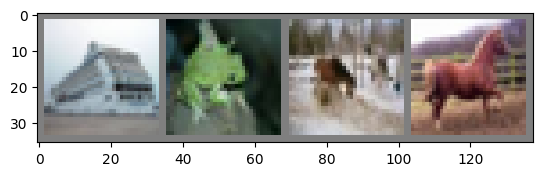

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.residual_conv = nn.Conv2d(3, 32, kernel_size=1)
        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        residual = self.residual_conv(residual)
        out += residual
        out = self.relu(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss_log.append(loss.item())

        preds = logits.argmax(dim=1)
        correct = preds.eq(target)
        acc = correct.float().mean()
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        correct = preds.eq(target)
        acc = correct.float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4683873994476835, train acc: 0.47768265215962635
 val loss: 1.223199504487058, val acc: 0.5640292553191489

Epoch 1
 train loss: 1.1657399551524106, train acc: 0.592187092007841
 val loss: 1.127787499224886, val acc: 0.6107934397585848

Epoch 2
 train loss: 1.053816074754028, train acc: 0.6336347611120458
 val loss: 1.062222764086216, val acc: 0.6299867021276596

Epoch 3
 train loss: 0.9903613896648888, train acc: 0.6566254244861917
 val loss: 1.0770318130229382, val acc: 0.630407801587531

Epoch 4
 train loss: 0.9501126410756294, train acc: 0.670059088597132
 val loss: 1.0236862494590435, val acc: 0.6431959220703612

Epoch 5
 train loss: 0.9275370681525584, train acc: 0.6762005419792161
 val loss: 0.9649424005062022, val acc: 0.6677304965384463

Epoch 6
 train loss: 0.9016296566077516, train acc: 0.6862880321699697
 val loss: 1.0521450930453362, val acc: 0.6432624114320633

Epoch 7
 train loss: 0.8805694370862552, train acc: 0.6953471859804673
 val loss: 0.97349

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4f}")

Потери на тестовой выборке: 0.8866; Точность на тестовой выборке: 0.6979


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

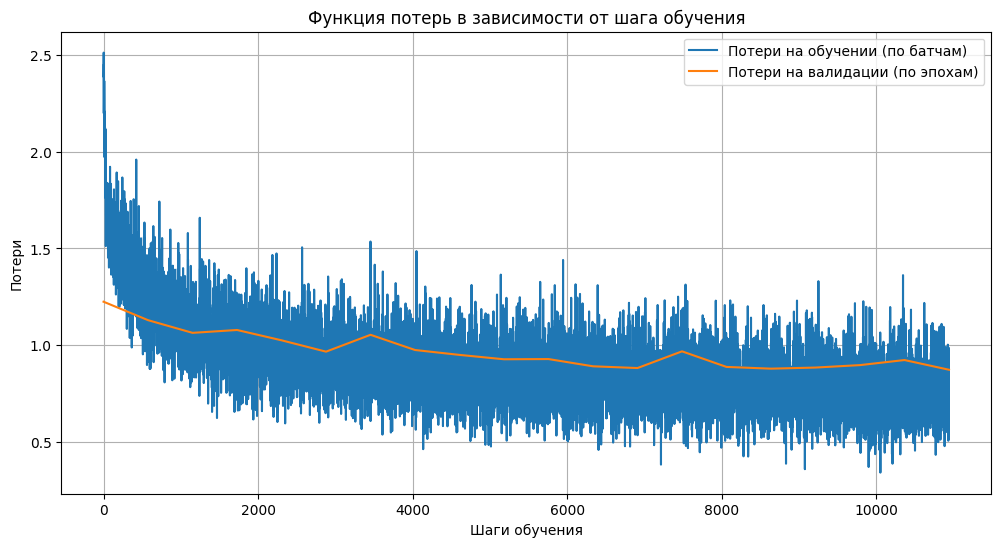

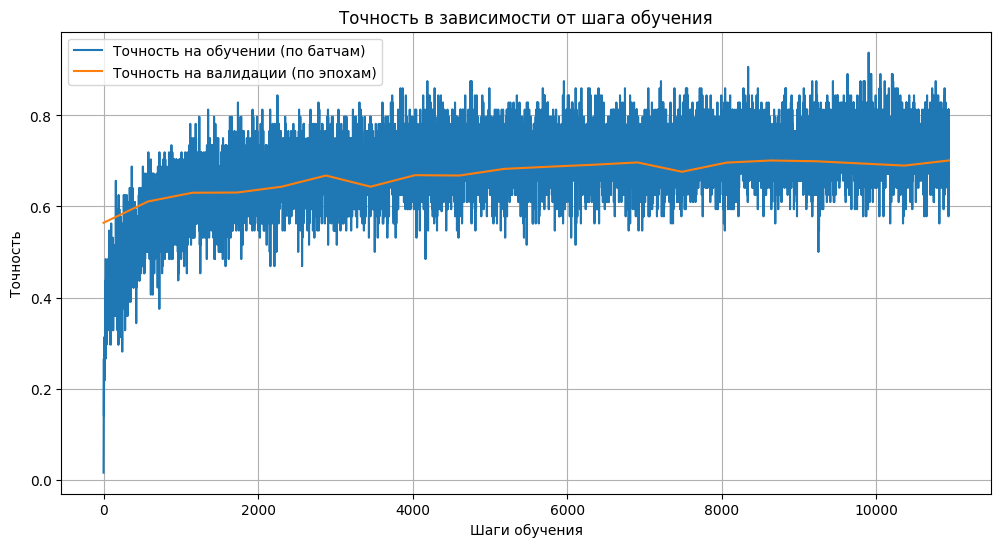

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss_log, label="Потери на обучении (по батчам)")
val_steps = np.linspace(0, len(train_loss_log), len(val_loss_log))
plt.plot(val_steps, val_loss_log, label="Потери на валидации (по эпохам)")
plt.title("Функция потерь в зависимости от шага обучения")
plt.xlabel("Шаги обучения")
plt.ylabel("Потери")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_acc_log, label="Точность на обучении (по батчам)")
plt.plot(val_steps, val_acc_log, label="Точность на валидации (по эпохам)")
plt.title("Точность в зависимости от шага обучения")
plt.xlabel("Шаги обучения")
plt.ylabel("Точность")
plt.legend()
plt.grid()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [14]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4643245682637913, train acc: 0.4774092453271423
 val loss: 1.2631451728496146, val acc: 0.5547429079705096

Epoch 1
 train loss: 1.151320999021722, train acc: 0.5967615566044446
 val loss: 1.1271137379585427, val acc: 0.6087765957446809

Epoch 2
 train loss: 1.0499829452695968, train acc: 0.6347487921906564
 val loss: 1.1802208096423048, val acc: 0.5955673759287976

Epoch 3
 train loss: 0.9903484145945561, train acc: 0.6519815879286535
 val loss: 0.9923605837720506, val acc: 0.6607047872340426

Epoch 4
 train loss: 0.9513271615535729, train acc: 0.6682309350322326
 val loss: 1.0114871945786983, val acc: 0.6435283688788719

Epoch 5
 train loss: 0.9157297981722481, train acc: 0.6807668452071097
 val loss: 0.9402595421101184, val acc: 0.678125

Epoch 6
 train loss: 0.8985108064668053, train acc: 0.6865410355806787
 val loss: 0.9398999414545425, val acc: 0.676817376055616

Epoch 7
 train loss: 0.8811837126938473, train acc: 0.6927845063985375
 val loss: 0.89837117474

Посчитайте точность на тестовой выборке:

In [15]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4f}")

Потери на тестовой выборке: 0.8280; Точность на тестовой выборке: 0.7157


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [16]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, n_epochs=20, train_loader=train_loader, val_loader=val_loader
)

Epoch 0
 train loss: 1.8587543495830279, train acc: 0.3467778793418647
 val loss: 1.6385141925608857, val acc: 0.4319148936170213

Epoch 1
 train loss: 1.5725993846408628, train acc: 0.44757932882204354
 val loss: 1.4885302051584772, val acc: 0.47808067380113806

Epoch 2
 train loss: 1.444934005275287, train acc: 0.49235276842466
 val loss: 1.4080623926000393, val acc: 0.5049645390916377

Epoch 3
 train loss: 1.3607828072263728, train acc: 0.5226029969438556
 val loss: 1.314423708712801, val acc: 0.5400709220703612

Epoch 4
 train loss: 1.2996203904831867, train acc: 0.5454263516056472
 val loss: 1.257674932987132, val acc: 0.564516844013904

Epoch 5
 train loss: 1.2457012950393356, train acc: 0.5637038065702867
 val loss: 1.2151478397085311, val acc: 0.5784352837724889

Epoch 6
 train loss: 1.204713921878194, train acc: 0.5813569144313471
 val loss: 1.202539526655319, val acc: 0.5808289007937655

Epoch 7
 train loss: 1.1603310499374349, train acc: 0.5959576587354461
 val loss: 1.16081

In [17]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4f}")

Потери на тестовой выборке: 0.9371; Точность на тестовой выборке: 0.6758


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

###ExponentialLR

Как устроено:

ExponentialLR уменьшает длину шага экспоненциально. На каждой эпохе длина шага уменьшается по формуле:
$$
\text{lr}_n = \text{lr}_0 \times \gamma^n
$$
Где:

$\text{lr}_0$ — начальная длина шага.
$\gamma$ — коэффициент уменьшения (от 0 до 1).

Используем начальную длину шага 0.1 и $\gamma = 0.9$.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, n_epochs=20, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler
)

Epoch 0
 train loss: 1.4725472517379676, train acc: 0.4743487202925046
 val loss: 1.3308407537480618, val acc: 0.544813829787234

Epoch 1
 train loss: 1.141788633257641, train acc: 0.6031886589810442
 val loss: 1.046374925907622, val acc: 0.6337987590343395

Epoch 2
 train loss: 1.0279548972354728, train acc: 0.6405066597178388
 val loss: 1.0414864294072415, val acc: 0.6375443263256804

Epoch 3
 train loss: 0.9591818475854026, train acc: 0.6656886589810442
 val loss: 1.0155341376649571, val acc: 0.6412012412192973

Epoch 4
 train loss: 0.915296453008704, train acc: 0.6814646448470121
 val loss: 0.9776285782773444, val acc: 0.6572916667512123

Epoch 5
 train loss: 0.8848377113695336, train acc: 0.6902299882942842
 val loss: 0.9458059011621678, val acc: 0.6766400710065315

Epoch 6
 train loss: 0.861008664262796, train acc: 0.70263939681829
 val loss: 0.9007985300206124, val acc: 0.6876994680851064

Epoch 7
 train loss: 0.8365577151505124, train acc: 0.7088338992059557
 val loss: 0.884850

In [19]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8316; Точность на тестовой выборке: 70.9793%



###CosineAnnealingLR

Как устроено:

CosineAnnealingLR изменяет длину шага по косинусоидальному закону, постепенно уменьшая её от начального значения до минимального ($\eta_{\text{min}}$) за указанное число эпох ($T_{\text{max}}$).

Формула длины шага:
$$
\text{lr}_t = \eta_{\text{min}} + \frac{1}{2} (\text{lr}_0 - \eta_{\text{min}}) \left(1 + \cos\left(\frac{t}{T_{\text{max}}} \pi\right)\right)
$$

Используем начальную длину шага 0.1, $T_{\text{max}} = 20$ (все эпохи), $\eta_{\text{min}} = 0$.

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, n_epochs=20, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler
)

Epoch 0
 train loss: 1.5024993725842923, train acc: 0.460800796583758
 val loss: 1.316953635723033, val acc: 0.5376773050490846

Epoch 1
 train loss: 1.2207306546092687, train acc: 0.5713755223607232
 val loss: 1.1260887419923824, val acc: 0.6056737589075211

Epoch 2
 train loss: 1.1001925521838383, train acc: 0.6166876142595978
 val loss: 1.0549705079261293, val acc: 0.6315824468085106

Epoch 3
 train loss: 1.0211157530709638, train acc: 0.6443629211437986
 val loss: 1.0655584898400814, val acc: 0.6336436170212766

Epoch 4
 train loss: 0.9754287632117542, train acc: 0.6632157547818242
 val loss: 0.9635731260827247, val acc: 0.6653147164811479

Epoch 5
 train loss: 0.9347882575919031, train acc: 0.675584356244347
 val loss: 0.9568027298501197, val acc: 0.664937943346957

Epoch 6
 train loss: 0.9032120420793293, train acc: 0.6898790481321555
 val loss: 0.9982580380236848, val acc: 0.6599512412192974

Epoch 7
 train loss: 0.8789657955849628, train acc: 0.695951129553305
 val loss: 0.8952

In [21]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8344; Точность на тестовой выборке: 71.1982%


###StepLR

Как работает

StepLR уменьшает длину шага на заданный коэффициент $\gamma$ каждые $ \text{step_size} $ эпох. Это позволяет периодически снижать скорость обучения, чтобы модель лучше сходилась.

Формула

$$
\text{lr}_t = \text{lr}_0 \times \gamma^{\lfloor t / \text{step_size} \rfloor}
$$


$\text{lr}_0$ — начальная длина шага.
$\gamma$ — коэффициент уменьшения длины шага (например, 0.1).
$\text{step_size}$ — количество эпох между уменьшением длины шага.

Используем начальную длину шага $\text{lr}_0 = 0.1$, $\gamma = 0.1$, и уменьшаем длину шага каждые 5 эпох $(\text{step_size} = 5$).

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, n_epochs=20, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler
)

Epoch 0
 train loss: 1.4837250424041608, train acc: 0.46951717160083695
 val loss: 1.2402742101791058, val acc: 0.5659352837724888

Epoch 1
 train loss: 1.1619815372025946, train acc: 0.5932072669104205
 val loss: 1.1041588146635826, val acc: 0.6144503547790202

Epoch 2
 train loss: 1.0531455574785333, train acc: 0.6331124314442413
 val loss: 1.1313075879786878, val acc: 0.6195035461415636

Epoch 3
 train loss: 0.9939296389410657, train acc: 0.6543973623289705
 val loss: 1.042417946521272, val acc: 0.6474512412192973

Epoch 4
 train loss: 0.9537007228983821, train acc: 0.6682390964009426
 val loss: 1.0048292451716483, val acc: 0.656781914893617

Epoch 5
 train loss: 0.829023902878247, train acc: 0.7157670084039733
 val loss: 0.8725005809296953, val acc: 0.7

Epoch 6
 train loss: 0.807800482515879, train acc: 0.7210311112717693
 val loss: 0.8635442923992238, val acc: 0.7039893617021277

Epoch 7
 train loss: 0.7976558165968664, train acc: 0.7257892074271137
 val loss: 0.8733323036356175,

In [23]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8522; Точность на тестовой выборке: 70.7006%


Your answers here:

Из трех методов наибольшую точность на тестовой выборке обеспечил CosineAnnealingLR (72.01%). Это связано с плавным изменением длины шага, которое позволяет модели исследовать пространство параметров более эффективно. CosineAnnealingLR улучшило качество на тестовой выборке, однако относительно MultiStepLR это улучшение незначительно.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

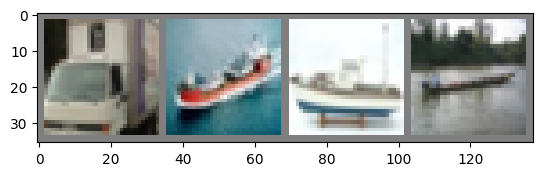

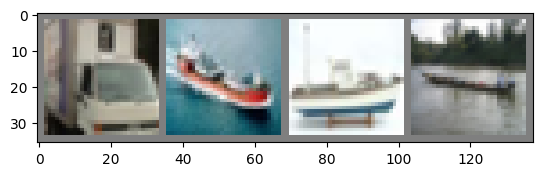

In [24]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [25]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4857304137629173, train acc: 0.4703904414307701
 val loss: 1.3182013400057528, val acc: 0.5294326241980207

Epoch 1
 train loss: 1.1916688214272424, train acc: 0.5793124837239002
 val loss: 1.1481179607675431, val acc: 0.6

Epoch 2
 train loss: 1.0641000537811294, train acc: 0.6276116480121229
 val loss: 1.0616310028319662, val acc: 0.6334663122258288

Epoch 3
 train loss: 1.0001033608830607, train acc: 0.6530344085240058
 val loss: 0.9900085839819401, val acc: 0.6609929079705096

Epoch 4
 train loss: 0.9570021399414299, train acc: 0.6693531274795532
 val loss: 1.0395469074553632, val acc: 0.6403147164811479

Epoch 5
 train loss: 0.9220056371453476, train acc: 0.6828235179676216
 val loss: 0.941111770589301, val acc: 0.6680851063829787

Epoch 6
 train loss: 0.9043192474454151, train acc: 0.6890629081011255
 val loss: 0.9894905285632357, val acc: 0.6542996454746165

Epoch 7
 train loss: 0.

Посчитайте точность на тестовой выборке:

In [26]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.7961; Точность на тестовой выборке: 72.6015%


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

###RandomCrop  
Как работает:  
RandomCrop случайным образом вырезает участок изображения заданного размера. Это помогает модели быть устойчивой к изменениям положения объекта в кадре.


In [27]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6665913452831875, train acc: 0.39495870334792615
 val loss: 1.5235481911517204, val acc: 0.43699024826922317

Epoch 1
 train loss: 1.3780121914429464, train acc: 0.505349797675117
 val loss: 1.2580275573629014, val acc: 0.5533909574468086

Epoch 2
 train loss: 1.2402167841111067, train acc: 0.5599985310102947
 val loss: 1.165469097583852, val acc: 0.591533688027808

Epoch 3
 train loss: 1.176260062283964, train acc: 0.5863802559414991
 val loss: 1.2646251059593039, val acc: 0.5698359929500743

Epoch 4
 train loss: 1.1345218874418757, train acc: 0.600495397009405
 val loss: 1.3175508466172725, val acc: 0.552437943346957

Epoch 5
 train loss: 1.111049706255932, train acc: 0.6096484069414505
 val loss: 1.151334775762355, val acc: 0.5985372340425532

Epoch 6
 train loss: 1.078642109194447, train acc: 0.6213028859176845
 val loss: 1.0760723943405963, val acc: 0.6232047872340426

Epoch 7
 train

In [28]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8453; Точность на тестовой выборке: 70.5215%


###RandomRotation  
Как работает:  
RandomRotation поворачивает изображение на случайный угол в заданном диапазоне. Это позволяет модели быть инвариантной к поворотам объекта.


In [29]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5474837368977352, train acc: 0.44460041791037186
 val loss: 1.3544739261586616, val acc: 0.5133643617021276

Epoch 1
 train loss: 1.2803983225247106, train acc: 0.5449325868372943
 val loss: 1.1804155372558756, val acc: 0.5790780143534884

Epoch 2
 train loss: 1.1650213170966892, train acc: 0.5909914469152308
 val loss: 1.1026346779884175, val acc: 0.6128989361702127

Epoch 3
 train loss: 1.0979375298759837, train acc: 0.6143289697671503
 val loss: 1.0809204512454094, val acc: 0.6249113476022761

Epoch 4
 train loss: 1.0537045673216936, train acc: 0.6302273765996343
 val loss: 1.0746064766924432, val acc: 0.623692376055616

Epoch 5
 train loss: 1.022227082871432, train acc: 0.6429387568555759
 val loss: 1.0581559067076824, val acc: 0.6301196808510638

Epoch 6
 train loss: 1.0018878389538097, train acc: 0.6499330765368516
 val loss: 0.9931532015191747, val acc: 0.6475842199427017

Epoch 7


In [30]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8348; Точность на тестовой выборке: 71.3973%


###ColorJitter  
Как работает:  
ColorJitter случайным образом изменяет яркость, контрастность, насыщенность и оттенок изображения. Это помогает модели справляться с различными условиями освещения и цветовыми искажениями.


In [31]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.534522044811214, train acc: 0.45296177208096716
 val loss: 1.357803966136689, val acc: 0.521719858240574

Epoch 1
 train loss: 1.2154924064275334, train acc: 0.5759418255886168
 val loss: 1.1386056019904767, val acc: 0.6092420212765958

Epoch 2
 train loss: 1.1067858707752263, train acc: 0.6136678963954095
 val loss: 1.0726404086072394, val acc: 0.6312943263256804

Epoch 3
 train loss: 1.0502111485714887, train acc: 0.6374461347921675
 val loss: 1.196383430349066, val acc: 0.5939494680851064

Epoch 4
 train loss: 1.0117437193337044, train acc: 0.6494025856093035
 val loss: 1.0879370544819122, val acc: 0.6301861702127659

Epoch 5
 train loss: 0.98005102147132, train acc: 0.6608938365575382
 val loss: 1.024209429101741, val acc: 0.6460549646235527

Epoch 6
 train loss: 0.9588799400347024, train acc: 0.668153401702588
 val loss: 1.0372305986729073, val acc: 0.643218085106383

Epoch 7
 train 

In [32]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8435; Точность на тестовой выборке: 71.6859%


###Комбинация аугментаций  







In [33]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7520663670691536, train acc: 0.36411677336344117
 val loss: 1.6327490223214982, val acc: 0.4004210993330529

Epoch 1
 train loss: 1.5414742806711843, train acc: 0.4442168321099534
 val loss: 1.4612798447304585, val acc: 0.4708333333756061

Epoch 2
 train loss: 1.432267665318205, train acc: 0.4876762862833152
 val loss: 1.3581201842490662, val acc: 0.518218085106383

Epoch 3
 train loss: 1.3489348602905133, train acc: 0.5216236288848263
 val loss: 1.3007865324933479, val acc: 0.5435283688788718

Epoch 4
 train loss: 1.296094867930334, train acc: 0.5417986093752999
 val loss: 1.334773775871764, val acc: 0.5370345744680851

Epoch 5
 train loss: 1.2559719378813092, train acc: 0.5559627188189156
 val loss: 1.2341072305719902, val acc: 0.5659796100981692

Epoch 6
 train loss: 1.2270674979011145, train acc: 0.5696901932930816
 val loss: 1.2626581255425797, val acc: 0.5539671986661059

Epoch 7
 t

In [34]:
test_loss, test_acc = test(net, test_loader)
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Потери на тестовой выборке: 0.8989; Точность на тестовой выборке: 69.1779%


Your answers here:

Методы RandomHorizontalFlip, RandomRotation и ColorJitter показали наилучшие результаты при обучении модели. Точность возросла до ~72%.
Использование всех методов вместе показало снижение точности до 69.18%. Это может быть связано с переусложнением задачи из-за сильного изменения исходных данных.
При этом все аугментации оказались хуже MultiStepLR.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [37]:
pip install wandb

In [38]:
import wandb

In [39]:
wandb.init(project="cifar10-classification", name="BasicBlockNet-Experiment")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [40]:
def train_epoch(model, optimizer, train_loader, epoch):
    loss_log = []
    acc_log = []
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        preds = outputs.argmax(dim=1)
        correct = preds.eq(target)
        acc = correct.float().mean()
        acc_log.append(acc.item())

        wandb.log({
            "Train Loss": loss.item(),
            "Train Accuracy": acc.item(),
            "Epoch": epoch + 1
        })

    return loss_log, acc_log

In [41]:
def test(model, loader, epoch, phase="Validation"):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = F.cross_entropy(outputs, target)
            loss_log.append(loss.item())

            preds = outputs.argmax(dim=1)
            correct = preds.eq(target)
            acc = correct.float().mean()
            acc_log.append(acc.item())

    avg_loss = np.mean(loss_log)
    avg_acc = np.mean(acc_log)

    wandb.log({
        f"{phase} Loss": avg_loss,
        f"{phase} Accuracy": avg_acc,
        "Epoch": epoch + 1
    })

    return avg_loss, avg_acc

In [42]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, epoch)
        val_loss, val_acc = test(model, val_loader, epoch, phase="Validation")

        print(f"Эпоха {epoch+1}/{n_epochs}")
        print(f"Потери на обучении: {np.mean(train_loss):.4f}, Точность на обучении: {np.mean(train_acc)*100:.2f}%")
        print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc*100:.2f}%\n")

        if scheduler is not None:
            scheduler.step()

In [43]:
wandb.init(project="cifar10-classification", name="BasicBlockNet-Experiment")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
wandb.watch(net)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

train(net, optimizer, n_epochs=20, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler)

test_loss, test_acc = test(net, test_loader, epoch=20, phase="Test")
print(f"Потери на тестовой выборке: {test_loss:.4f}; Точность на тестовой выборке: {test_acc:.4%}")

Files already downloaded and verified
Files already downloaded and verified
Эпоха 1/20
Потери на обучении: 1.4861, Точность на обучении: 46.95%
Потери на валидации: 1.3090, Точность на валидации: 53.35%

Эпоха 2/20
Потери на обучении: 1.1881, Точность на обучении: 58.33%
Потери на валидации: 1.1427, Точность на валидации: 60.45%

Эпоха 3/20
Потери на обучении: 1.0583, Точность на обучении: 62.92%
Потери на валидации: 1.0722, Точность на валидации: 63.24%

Эпоха 4/20
Потери на обучении: 0.9946, Точность на обучении: 65.39%
Потери на валидации: 1.0165, Точность на валидации: 65.02%

Эпоха 5/20
Потери на обучении: 0.9565, Точность на обучении: 66.70%
Потери на валидации: 0.9769, Точность на валидации: 65.74%

Эпоха 6/20
Потери на обучении: 0.9210, Точность на обучении: 68.12%
Потери на валидации: 0.9345, Точность на валидации: 67.10%

Эпоха 7/20
Потери на обучении: 0.9054, Точность на обучении: 69.04%
Потери на валидации: 0.9465, Точность на валидации: 67.41%

Эпоха 8/20
Потери на обучени

Ссылка на графики в wandb: https://wandb.ai/vpalysaev-hse-university/cifar10-classification/runs/34ckbiwt?nw=nwuservpalysaev
